# 1. Introduction 

A brief description of your approach to the problem and the results that you have obtained on the training data.

<font color="red"><b>!!!!!!!! FILL THIS IN PLS<b>

# 2. Data Import

This section is how you import the data into the notebook. It should be written in such a way that I can modify it to run on my own machine by simply changing the location of the training data and any additional data sources that you have used.


## 2.1 Import the libraries

In [107]:
# The dependencies for anaconda can be downloaded from the main directory.
# There are some version control works have to be done for the incompatibility
# e.g. 'pandas_ml does not work with pandas >= 0.25.0, so we used the pandas = 0.24.2'
import numpy as np
import pandas as pd
import pandas_profiling
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from pandas_ml import ConfusionMatrix

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)
%matplotlib inline

# from Ipython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" #"last_expr"

### 2.2 Data dictionary
Below is a data dictionary from https://www.kaggle.com/yapsoonchung/eda-on-default-of-credit-card-clients-dataset/comments & https://www.researchgate.net/publication/326171439_Default_Payment_Analysis_of_Credit_Card_Clients

### 2.3 Load the datasets

In [168]:
df_train = pd.read_csv("DataFiles/CreditCard_train.csv",header = 1)
df_test = pd.read_csv("DataFiles/CreditCard_test.csv",header = 1)
all_data = pd.concat([df_train,df_test])
# all_data.reindex(range(1,30001))
# all_data["ID"] = range(1,30001) #rerange the ID
# all_data.set_index('ID') #set the ID as index

# 3. Data Transformation & EDA

any exploration of the data that you performed such as visualization, feature extraction, etc.

### 3.1 Data Transformation

All the column are useful for the data exploration and training but except for the ID. It(ID) does not make sense for default and so no improvement on current classifiers according to the tests, so we deleted below.

In [109]:
#check data types, features, null values
pandas_profiling.ProfileReport(all_data)

Number of variables,26
Number of observations,30000
Total Missing (%),0.0%
Total size in memory,6.0 MiB
Average record size in memory,208.0 B
Numeric,19
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,5


In [110]:
general_stats= all_data.describe().iloc[:,0:6]
pay_status_stats = all_data.describe().iloc[:,6:12]
bill_stats = all_data.describe().iloc[:,12:18]
payed_stats = all_data.describe().iloc[:,18:24]

In [111]:
general_stats

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000


It shows that the there are undocumented(duplicate) labels in the datasets, we should catogrize and take care of them at the end of 3.1Transformation as a cleaning work. The education 0,5,6 can be catogrized as 4(others). Marriage 0 can be catogrized as 3(others).

In [112]:
pay_status_stats

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


The payment status looks good and nothing more can do in data transformation, but we can do a bit more after exporate the data in section 3.2 and extract more tense information of PAY status in section 4 as feature extration.

In [113]:
bill_stats

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [114]:
payed_stats

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


The bill amount and pay amount looks good and nothing more can do in data transformation, but we can do a bit more after exporation. They looks like they has a really wide range, we probably can normalise them to a sensible range.

### use boxplots to visualize outliners

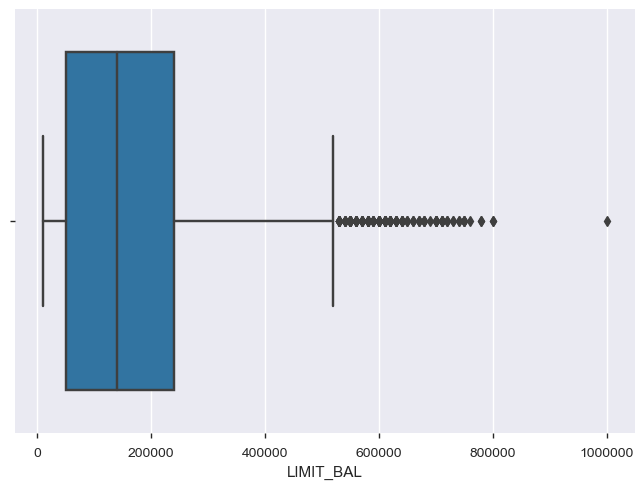

In [115]:
sns.boxplot(x=all_data['LIMIT_BAL'])

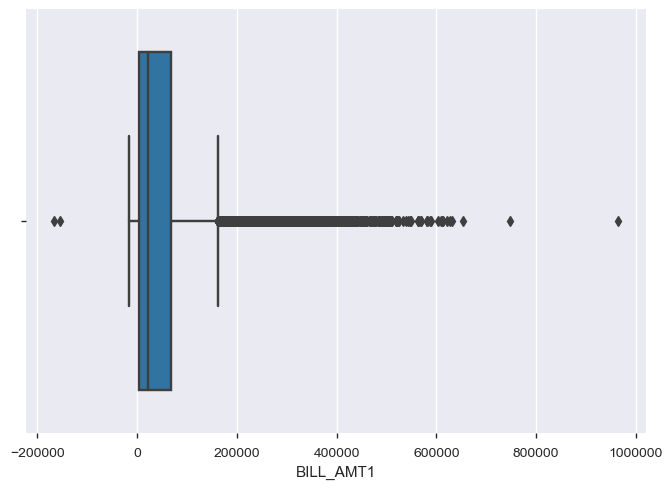

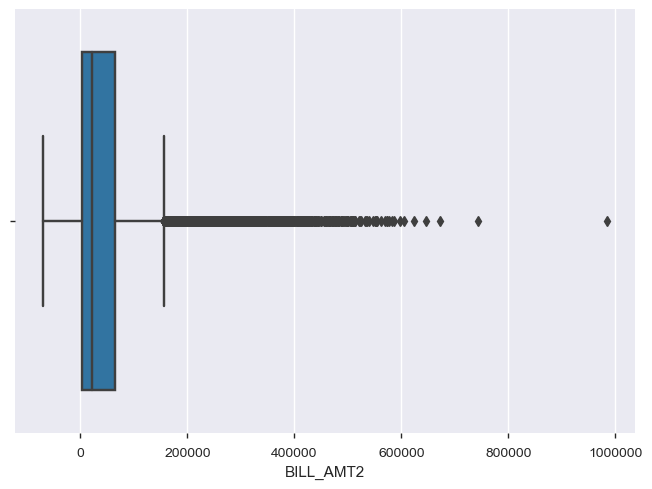

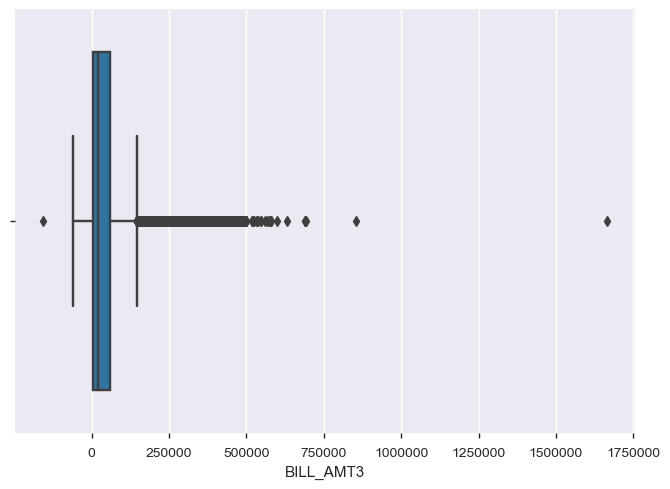

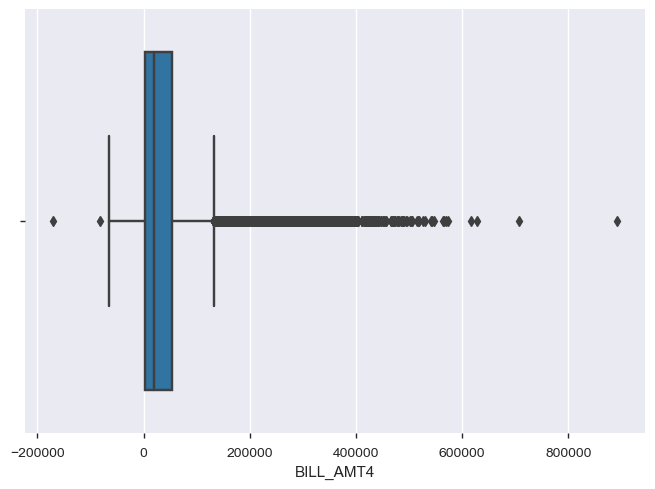

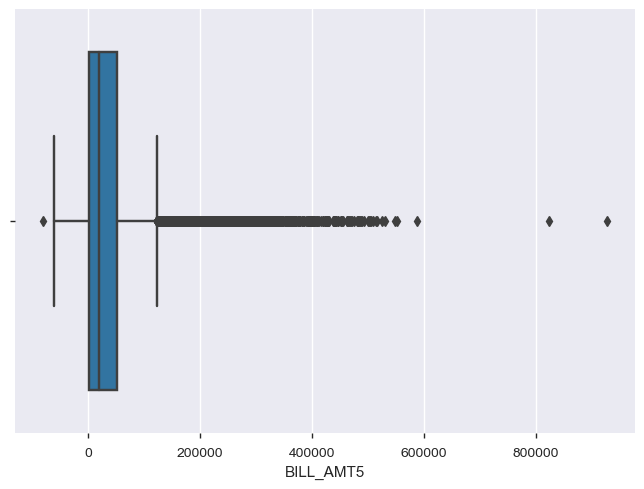

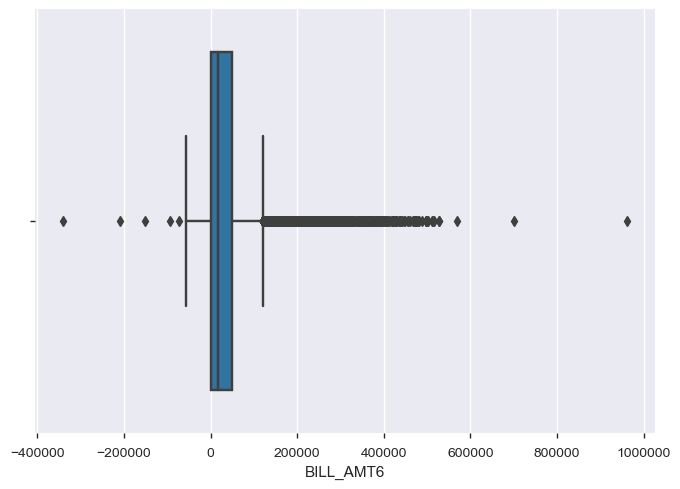

In [116]:
for c in all_data.columns[12:18]:
    sns.boxplot(x=all_data[c])
    plt.show()

Probrably will only keep billamt1

In [117]:
# all_data.iplot()

## 3.2 Data Exploration (EDA)
ADDDDDDD We are exploring the data sets by calculating the differences, skeness...........(explain more about the strategy we used in this part)

### 3.2.0 Create the datasets for data exploration

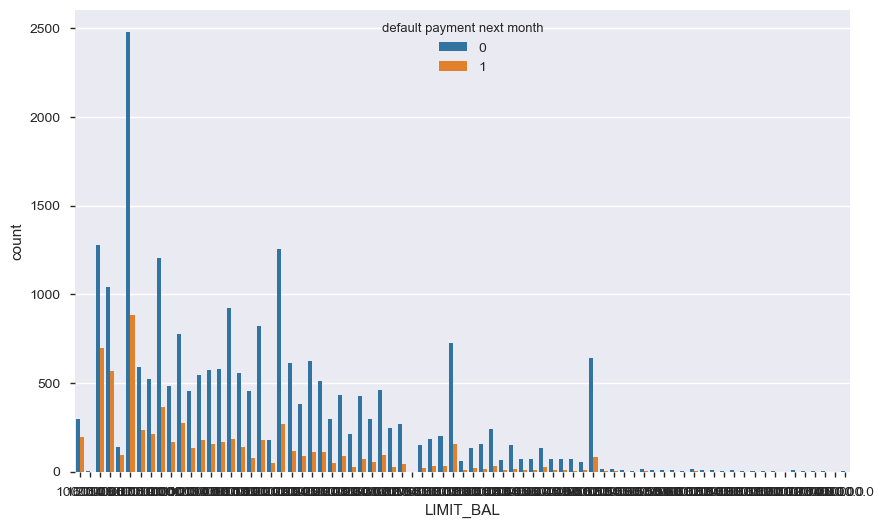

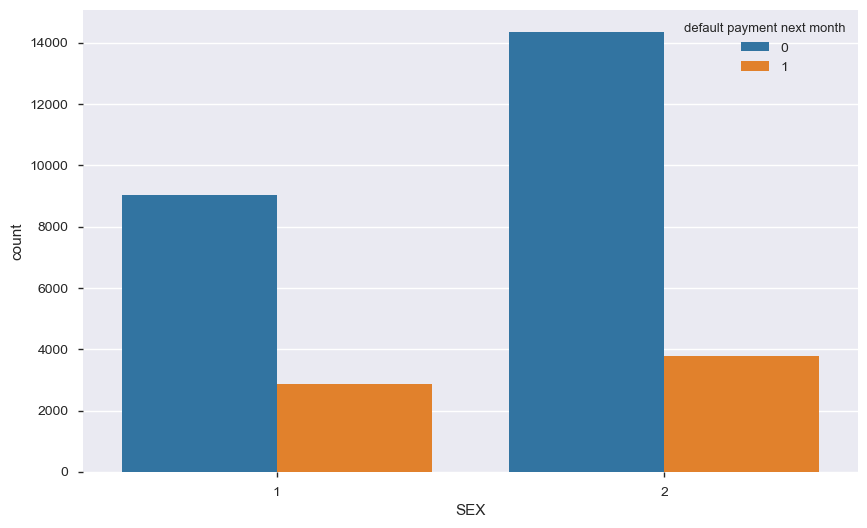

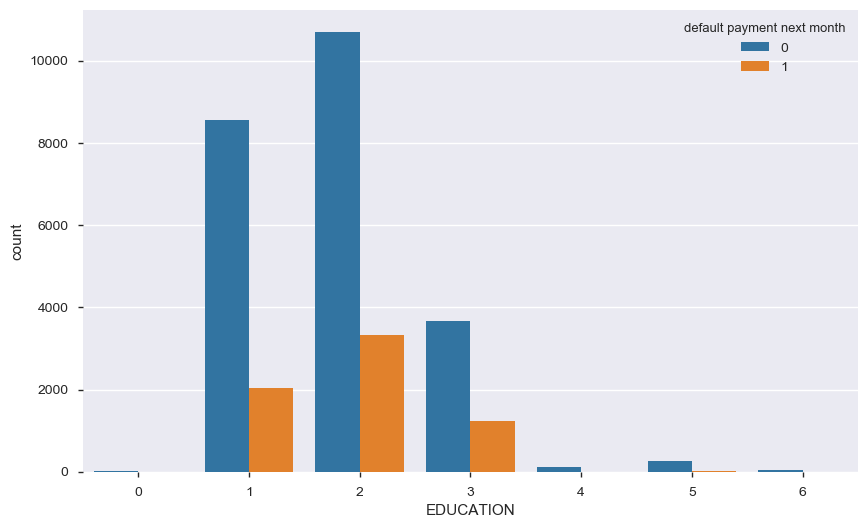

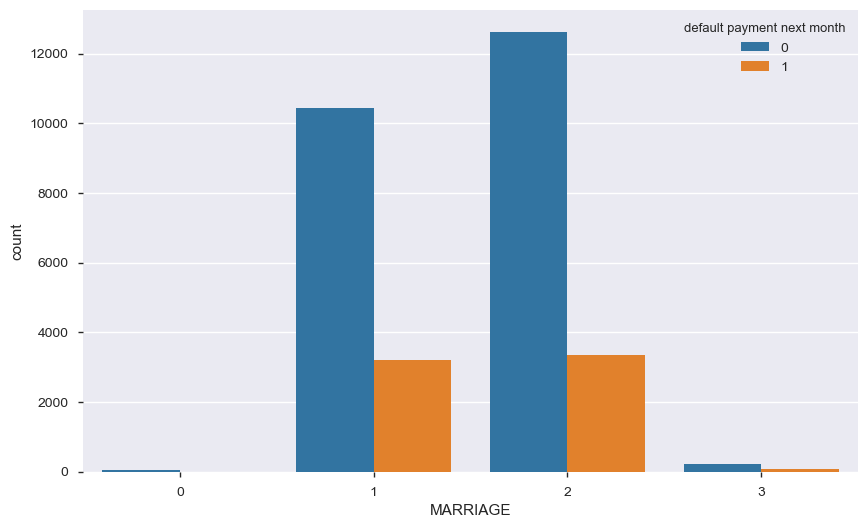

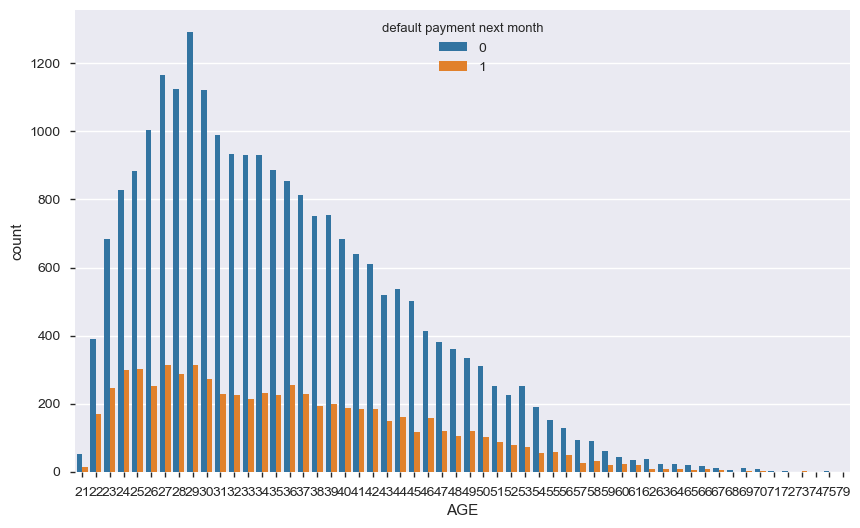

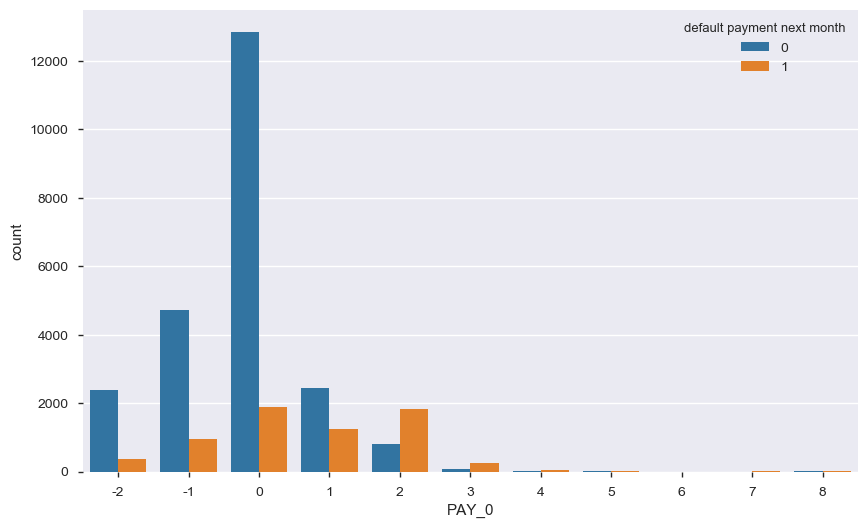

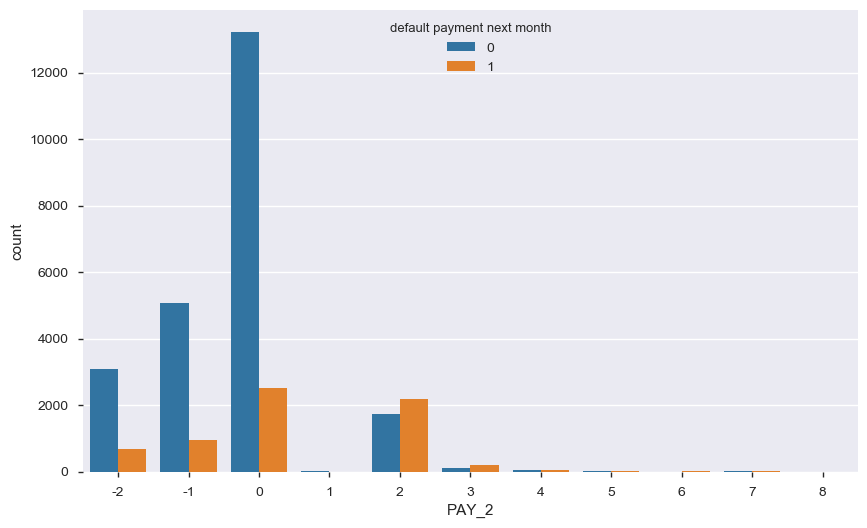

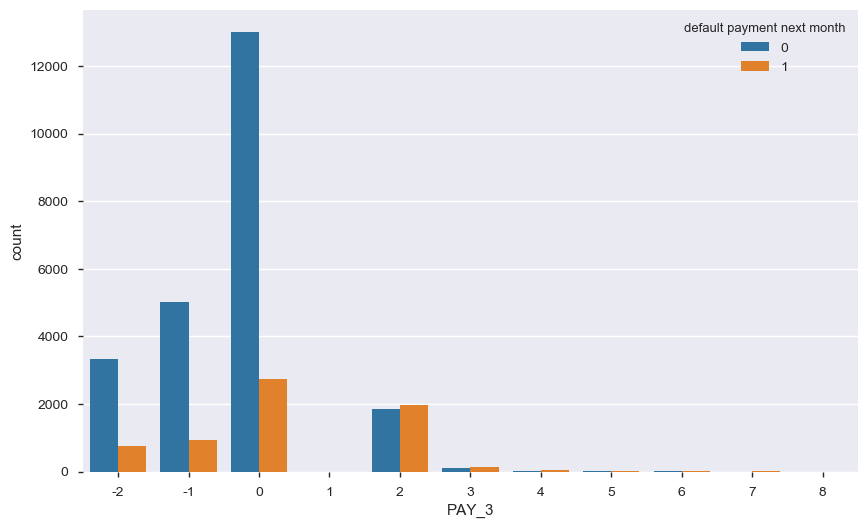

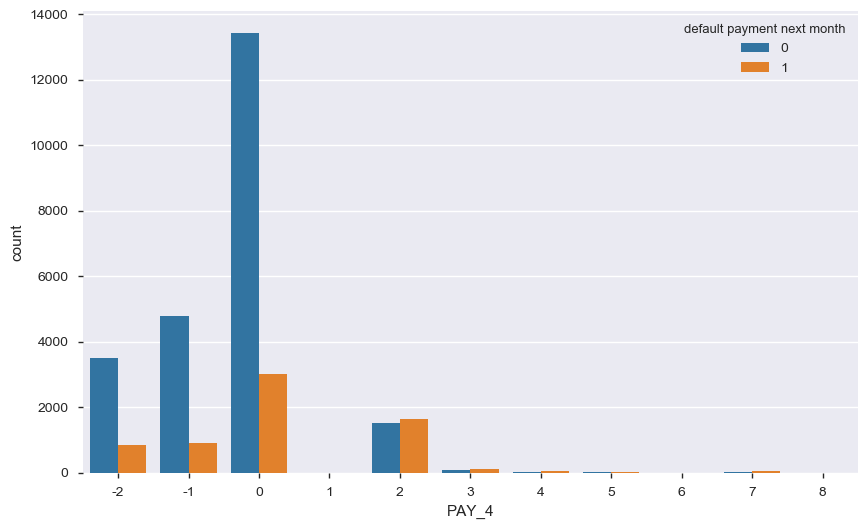

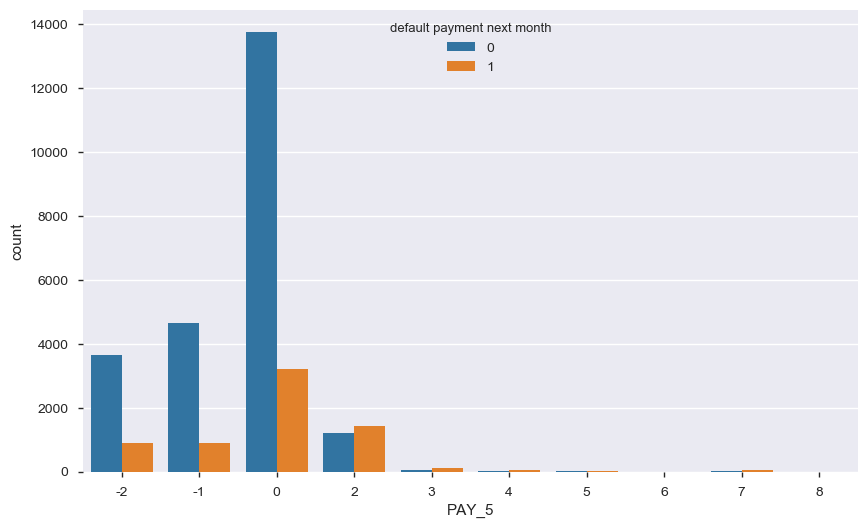

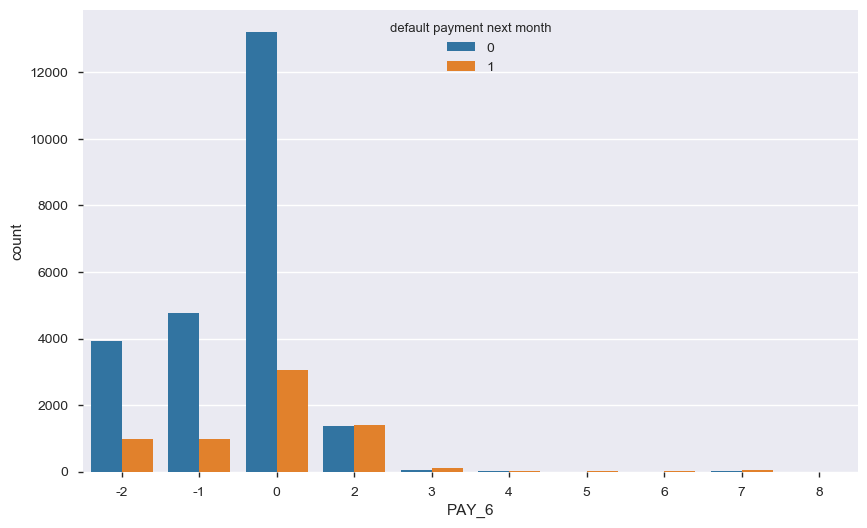

In [175]:
for c in all_data.columns[1:12]:
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(x = c, hue="default payment next month", data = all_data)

In [119]:
pay_status_sum = all_data.iloc[:, 6:12].sum(axis=1)
bill_sum = all_data.iloc[:, 12:18].sum(axis=1)
pay_sum = all_data.iloc[:, 18:24].sum(axis=1)

### 3.2.3 Explore sum of pay status

Because the the encoding for payment status ranged from -2 to infinitive, and the less is the better. We can add up all the payment status and use the sum to plot a graph. We can divide the data into two groups which are "ltz": less than zero and "mtz":more than zero, and investigate the percentage of getting default next month in each group.

In [ ]:
pay_status_sum = all_data.iloc[:, 6:12].sum(axis=1)
bill_sum = all_data.iloc[:, 12:18].sum(axis=1)
pay_sum = all_data.iloc[:, 18:24].sum(axis=1)

Text(0, 0.5, 'Frequency')

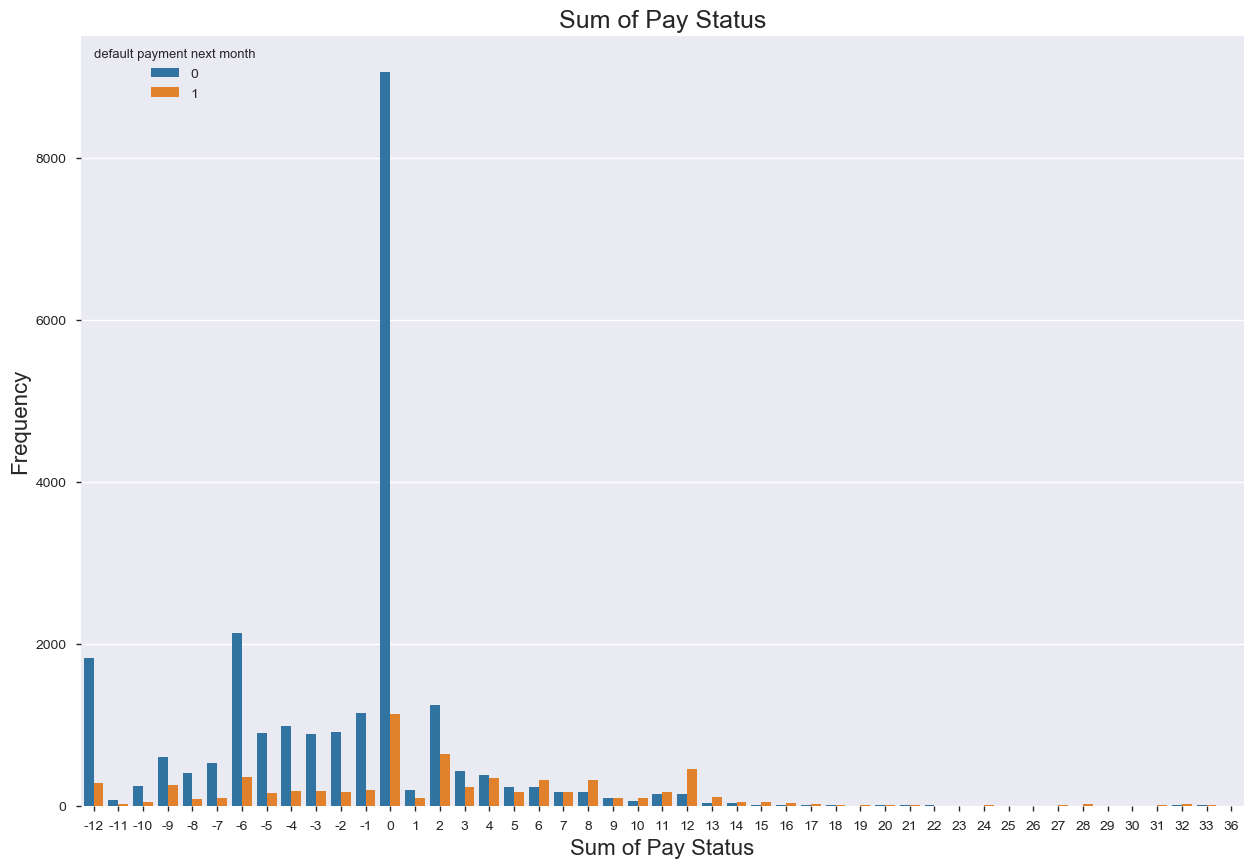

In [121]:
all_data["cumsum"]  = pay_status_sum
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x = "cumsum", hue="default payment next month", data = all_data)
plt.title('Sum of Pay Status', fontsize=18)
plt.xlabel('Sum of Pay Status', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

In [122]:
ltz = all_data[all_data["cumsum"]<=0]
mtz = all_data[all_data["cumsum"]>0]
ltz_1 = ltz["default payment next month"][ltz["default payment next month"]==1].count()/len(ltz)
mtz_1 = mtz["default payment next month"][mtz["default payment next month"]==1].count()/len(mtz)

print("Percentage of individuals getting default with a sum of pay status <=0: {:.3f}%".format(ltz_1*100))
print("Percentage of individuals getting default with a sum of pay status >0: {:.3f}%".format(mtz_1*100))

Percentage of individuals getting default with a sum of pay status <=0: 13.815%
Percentage of individuals getting default with a sum of pay status >0: 48.745%


From the above results, we can see that only 13.8% of the "ltz" group will get a default of 1, while 48.7% the "mtz" group will get a default of 1.

### 3.2.4 Explore limit-bill

In [123]:
all_data["limit-bill"] = all_data['LIMIT_BAL']*6 - bill_sum

In [124]:
spent_less_than_limit = all_data[all_data["limit-bill"]>=0]
spent_more_than_limit= all_data[all_data["limit-bill"]<0]
sll_1 = spent_less_than_limit["default payment next month"][spent_less_than_limit["default payment next month"]==1].count()/len(spent_less_than_limit)
sml_1 = spent_more_than_limit["default payment next month"][spent_more_than_limit["default payment next month"]==1].count()/len(spent_more_than_limit)

print("Percentage of individuals getting default who spent less than the limit: {:.3f}%".format(sll_1*100))
print("Percentage of individuals getting default who spent more than the limit: {:.3f}%".format(sml_1*100))

Percentage of individuals getting default who spent less than the limit: 21.857%
Percentage of individuals getting default who spent more than the limit: 34.223%


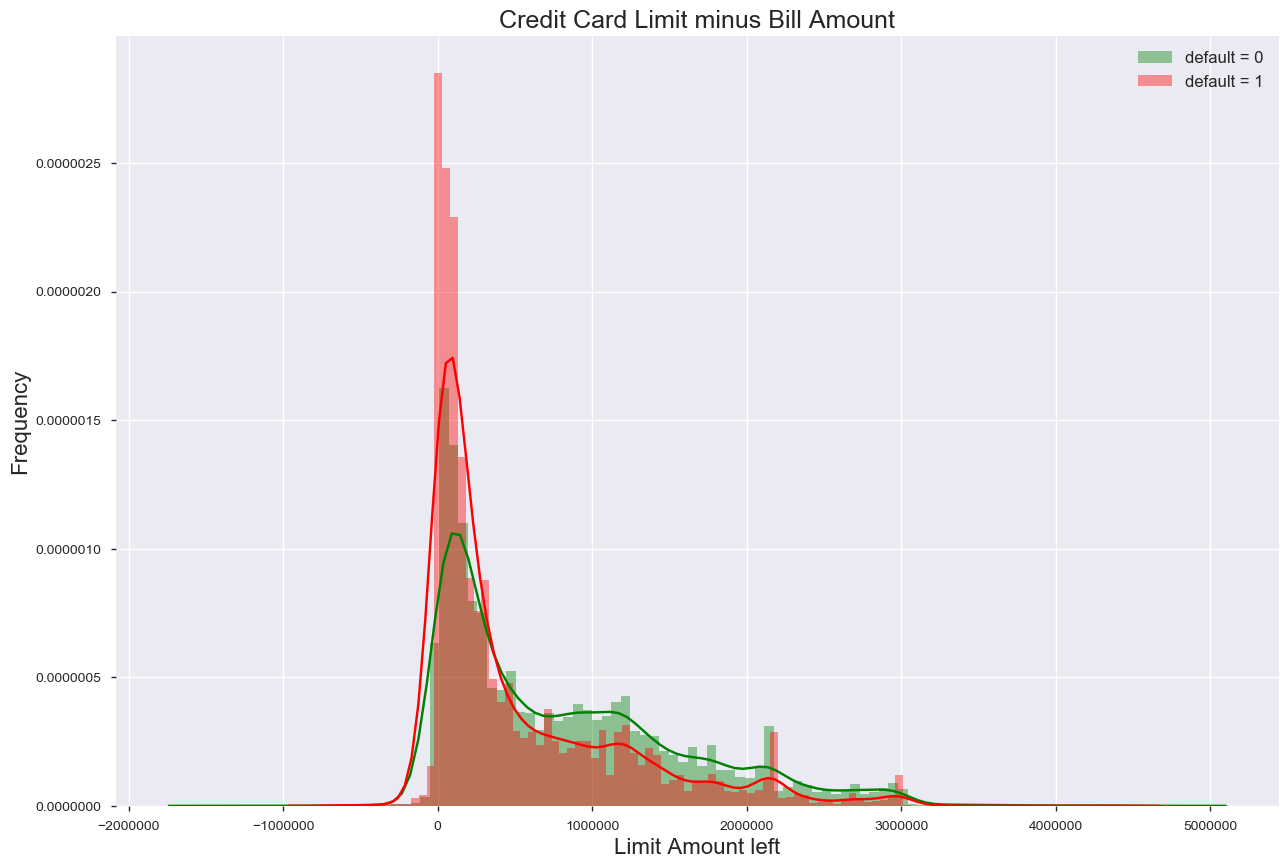

In [125]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(all_data["limit-bill"][all_data["default payment next month"]==0],color='green', bins=100,label = 'default = 0')
sns.distplot(all_data["limit-bill"][all_data["default payment next month"]==1],color='red', bins=100,label = 'default = 1')
plt.title('Credit Card Limit minus Bill Amount', fontsize=18)
plt.xlabel('Limit Amount left', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(prop={'size': 12})

### 3.2.5 Explore Bill - Pay

In [126]:
# bill_sum.replace(0, 0.001, inplace = True) #so that the denominator won't be zero
all_data["bill-pay"] = bill_sum - pay_sum

In [127]:
paid_less_than_bill = all_data[all_data["bill-pay"]>0]
paid_more_than_bill = all_data[all_data["bill-pay"]<=0]
plb_1 = paid_less_than_bill["default payment next month"][paid_less_than_bill["default payment next month"]==1].count()/len(paid_less_than_bill)
pmb_1 = paid_more_than_bill["default payment next month"][paid_more_than_bill["default payment next month"]==1].count()/len(paid_more_than_bill)

print("Percentage of individuals getting default who paid less than the bill: {:.3f}%".format(plb_1*100))
print("Percentage of individuals getting default who paid more than the bill: {:.3f}%".format(pmb_1*100))

Percentage of individuals getting default who paid less than the bill: 22.472%
Percentage of individuals getting default who paid more than the bill: 20.178%


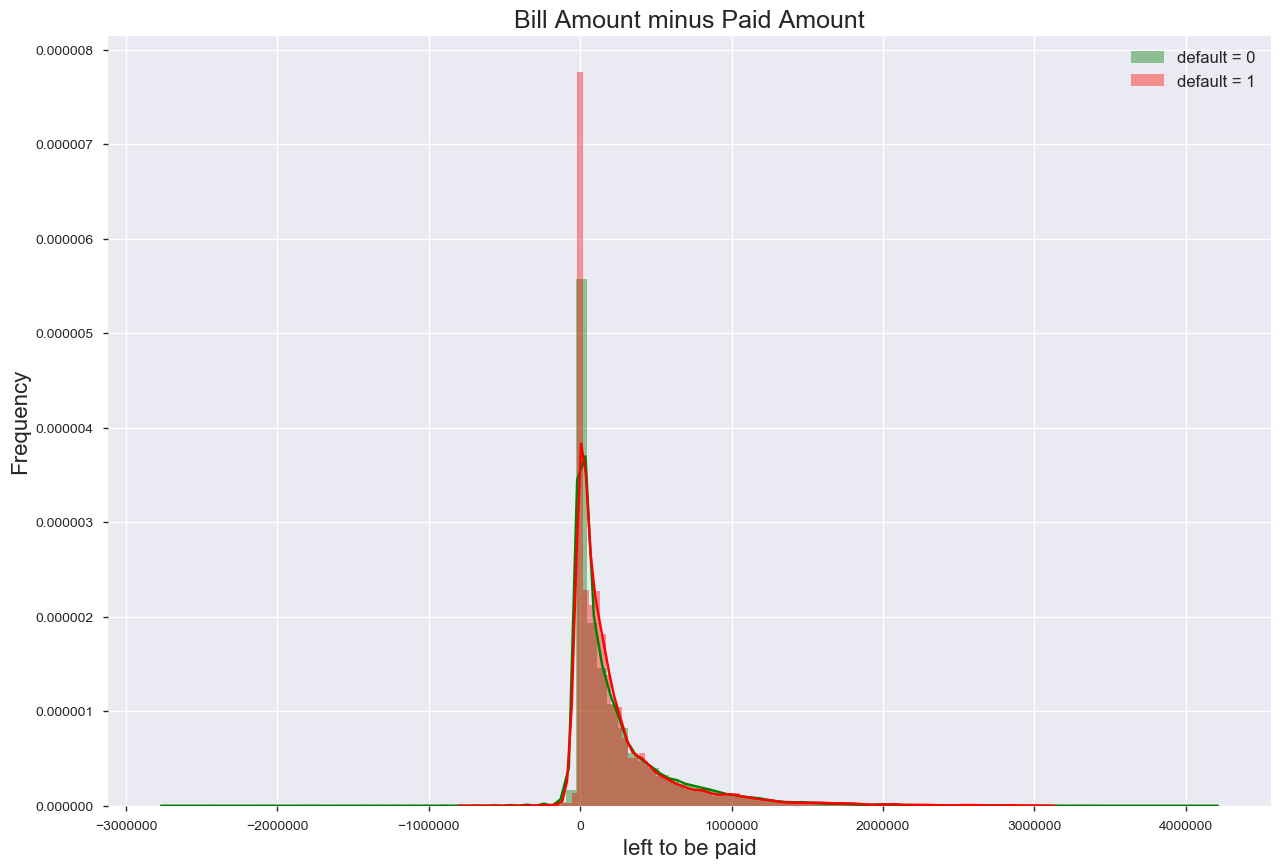

In [128]:
fig, ax = plt.subplots(figsize=(15,10))
# plt.plot(paid_less_than_bill["bill-pay"][paid_less_than_bill["default payment next month"]==0])
sns.distplot(all_data["bill-pay"][all_data["default payment next month"]==0],color='green', bins=100,label = 'default = 0')
sns.distplot(all_data["bill-pay"][all_data["default payment next month"]==1],color='red', bins=100,label = 'default = 1')
plt.title('Bill Amount minus Paid Amount', fontsize=18)
plt.xlabel('left to be paid', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(prop={'size': 12})

### 3.2.6 Evaluate the skewness of the distribution

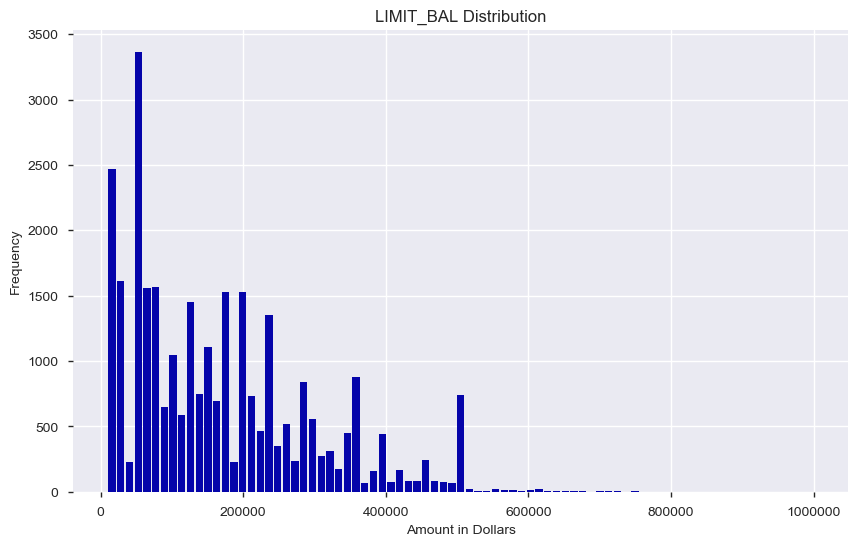

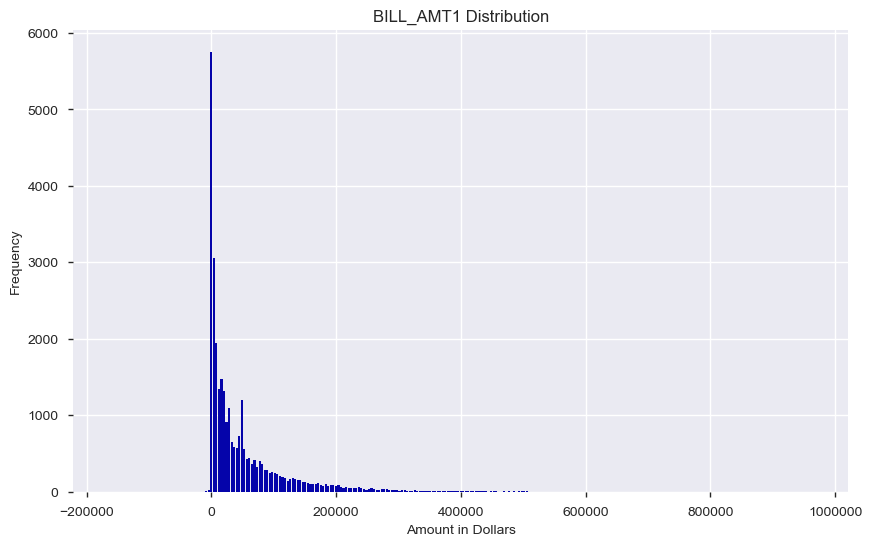

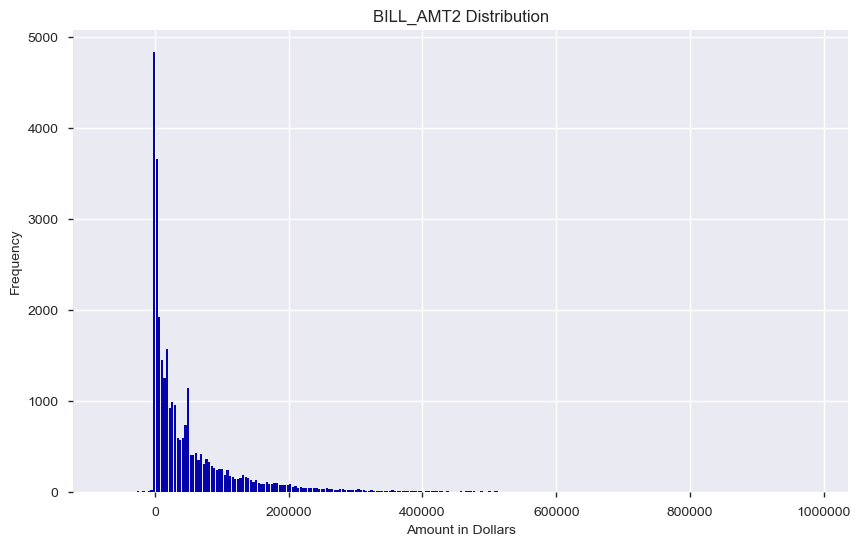

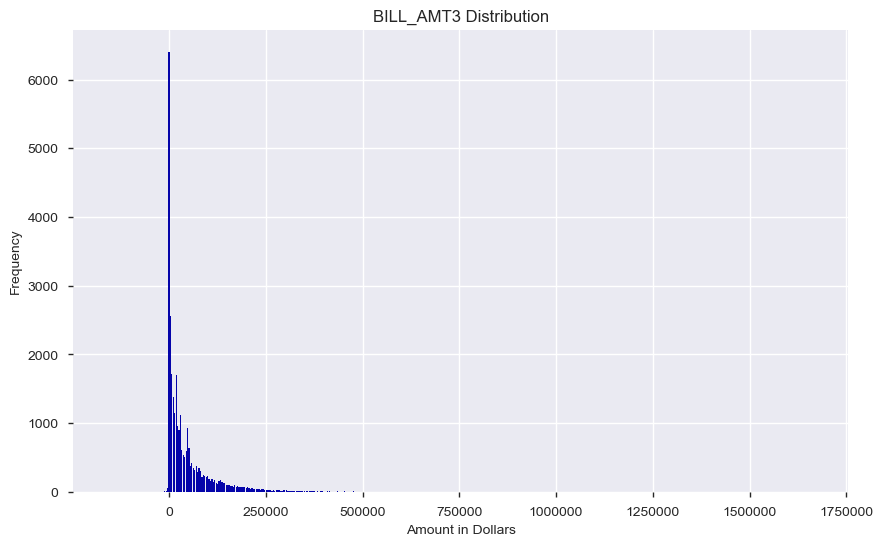

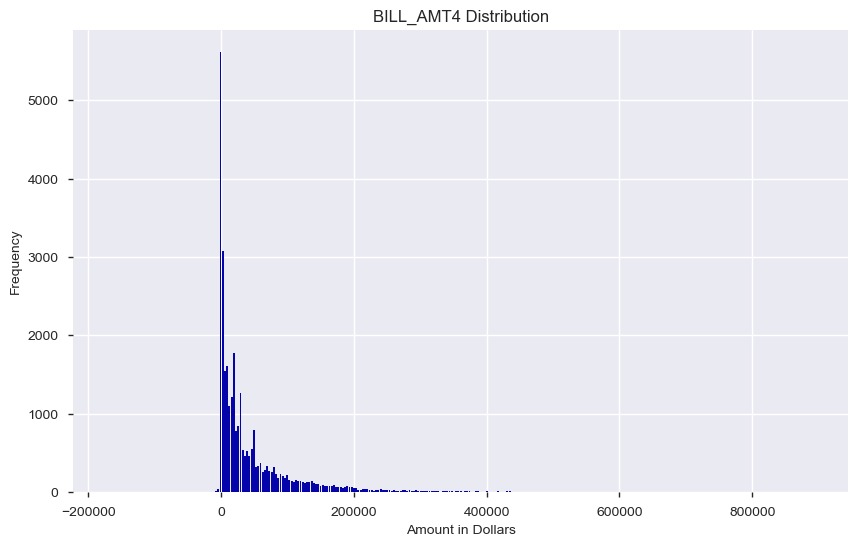

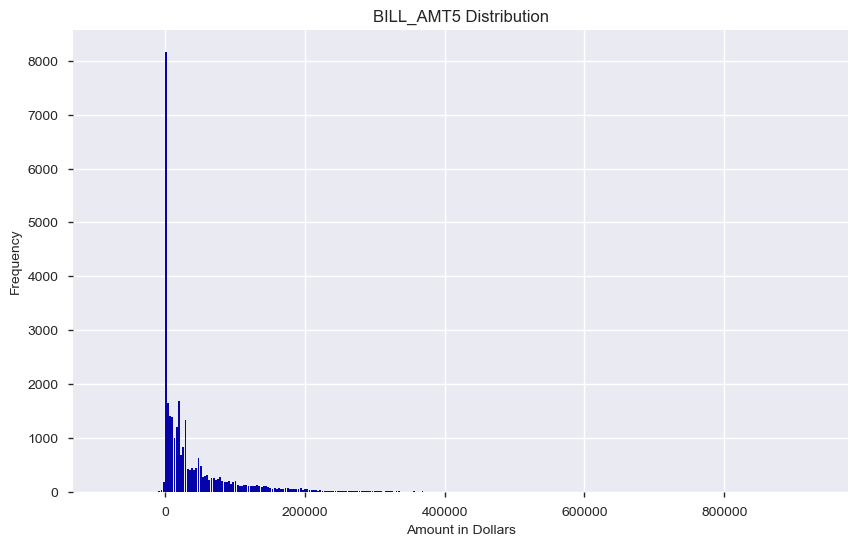

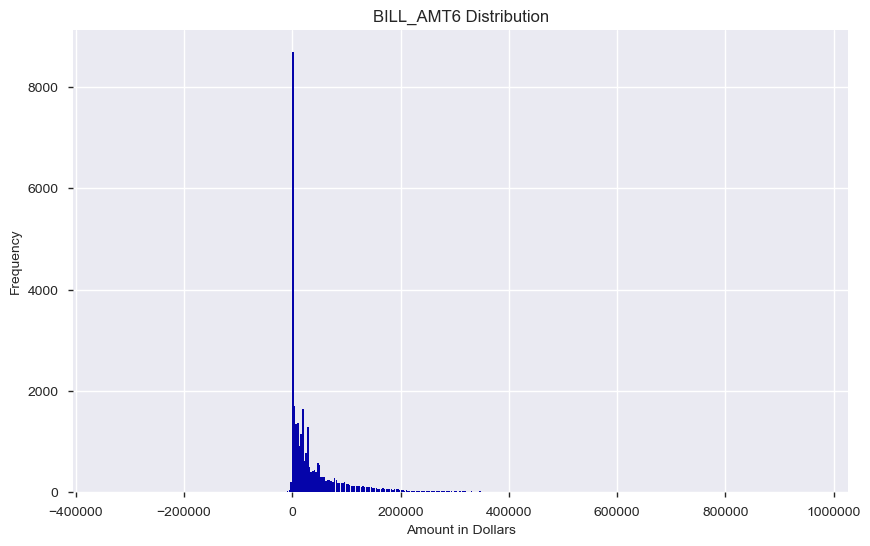

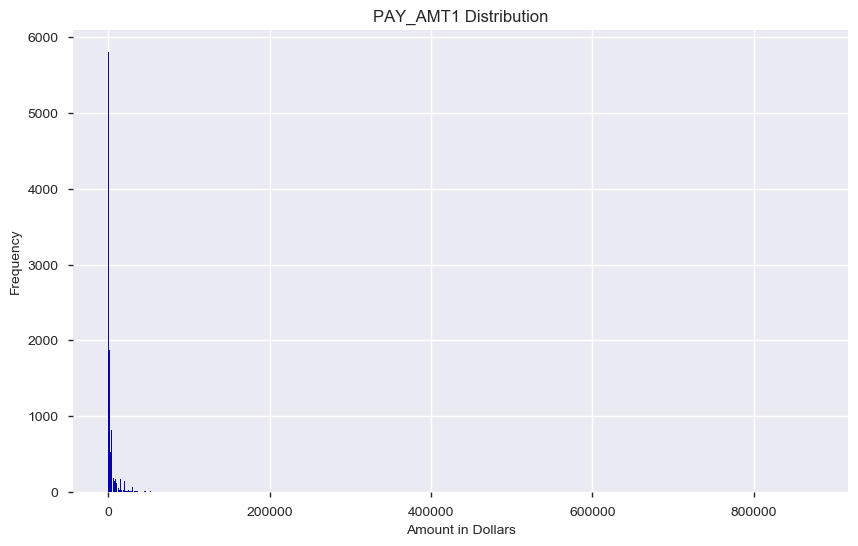

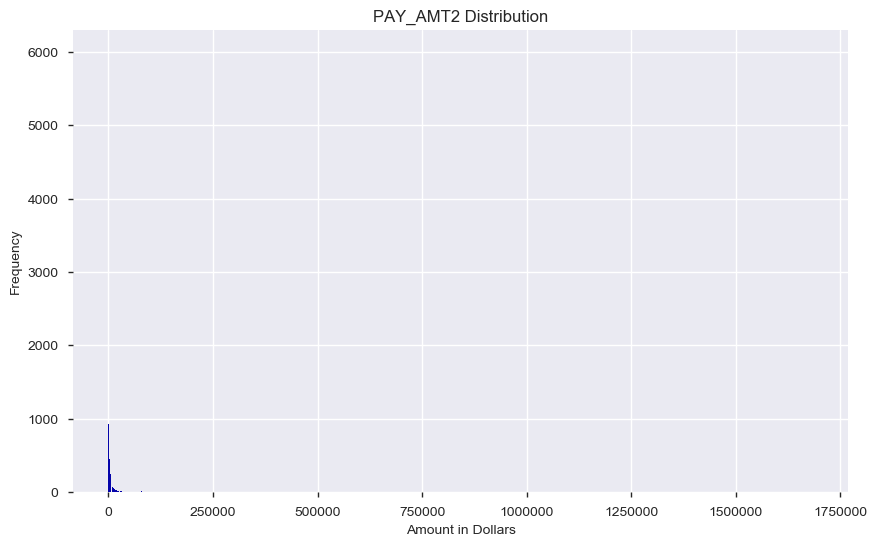

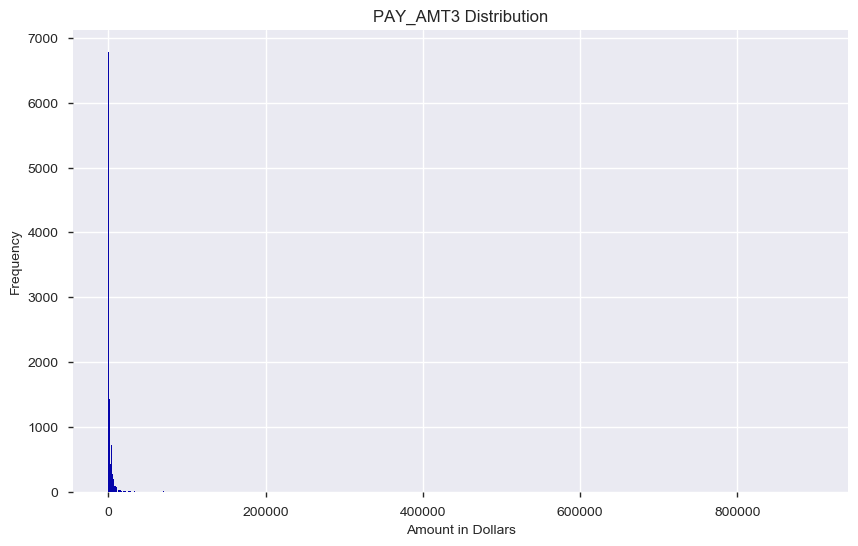

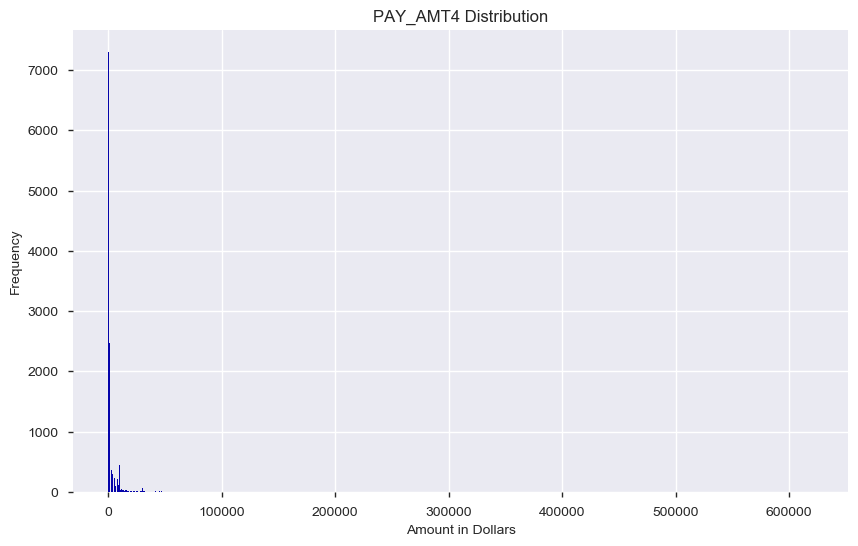

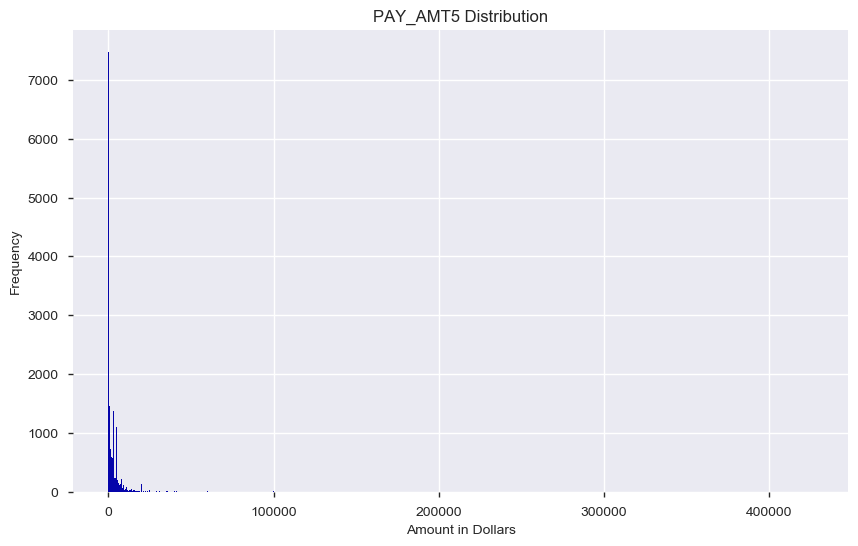

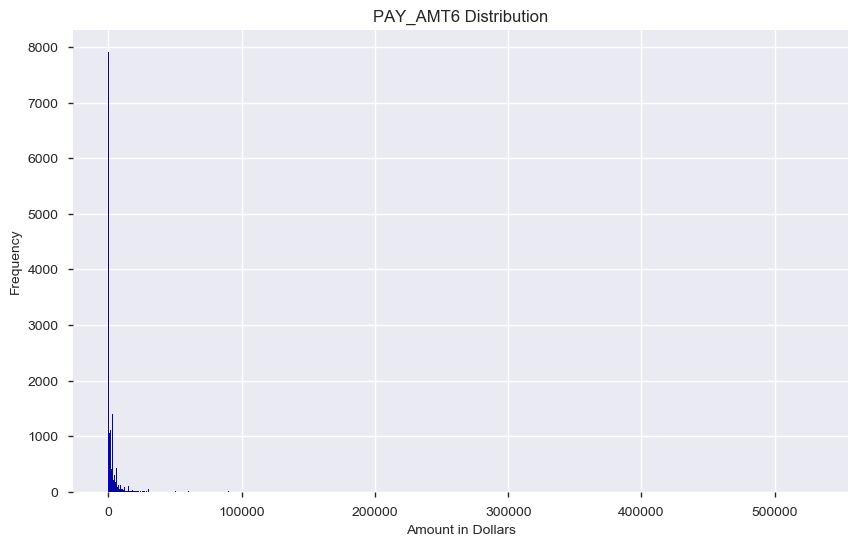

In [129]:
bills = ['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
for c in bills:
    fig, ax = plt.subplots(figsize=(10,6))
    plt.title(c + " Distribution", fontsize=12)
    plt.xlabel('Amount in Dollars', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    n, bins, patches = plt.hist(x=all_data[c], bins='auto', color='#0504aa', rwidth=0.85)

From the above diagram, we can see that the data is highly skewed, transformation is necessary  before trainning so that the data do not negatively affect the performance of a learning algorithm. Later I will be using a cubic root transformation significantly to reduce the range of values caused by outliers.

### 3.2.7 ADDDDDDDD Summary of EDA All below needs more explanation

1. is this dataset balanced?
    From the ProfileReport we can know that this dataset is not balanced. To solve this problem:

    1. talk about evaluatio metrics 
    2. ...

    use this source and your own findings to fill this part in 
    https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5
2. is any feature skewed?
3. is there any correlation?


In [130]:
all_data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'cumsum', 'limit-bill', 'bill-pay'],
      dtype='object')

# 4. Data Cleaning  and Data Transformation

In [131]:
# check for unique values in each columns
for c in all_data.columns[2:12]:
    unique_vals = all_data[c].unique()
    print(c,"-"*5,unique_vals)

SEX ----- [2 1]
EDUCATION ----- [2 1 3 5 4 6 0]
MARRIAGE ----- [1 2 3 0]
AGE ----- [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70
 72 64 65 71 69 68 79 74]
PAY_0 ----- [ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_2 ----- [ 2  0 -1 -2  3  5  7  4  1  6  8]
PAY_3 ----- [-1  0  2 -2  3  4  6  7  1  5  8]
PAY_4 ----- [-1  0 -2  2  3  4  5  7  6  1  8]
PAY_5 ----- [-2  0 -1  2  3  5  4  7  8  6]
PAY_6 ----- [-2  2  0 -1  3  6  4  7  8  5]


In EDUCATION column, 0, 5 and 6 both encodes for 'unknown'. 
In MARRIAGE column, 0 is an extra category. 
To clean this:
    1. covert 0, 5, 6 to 4, which encodes for 'others'.

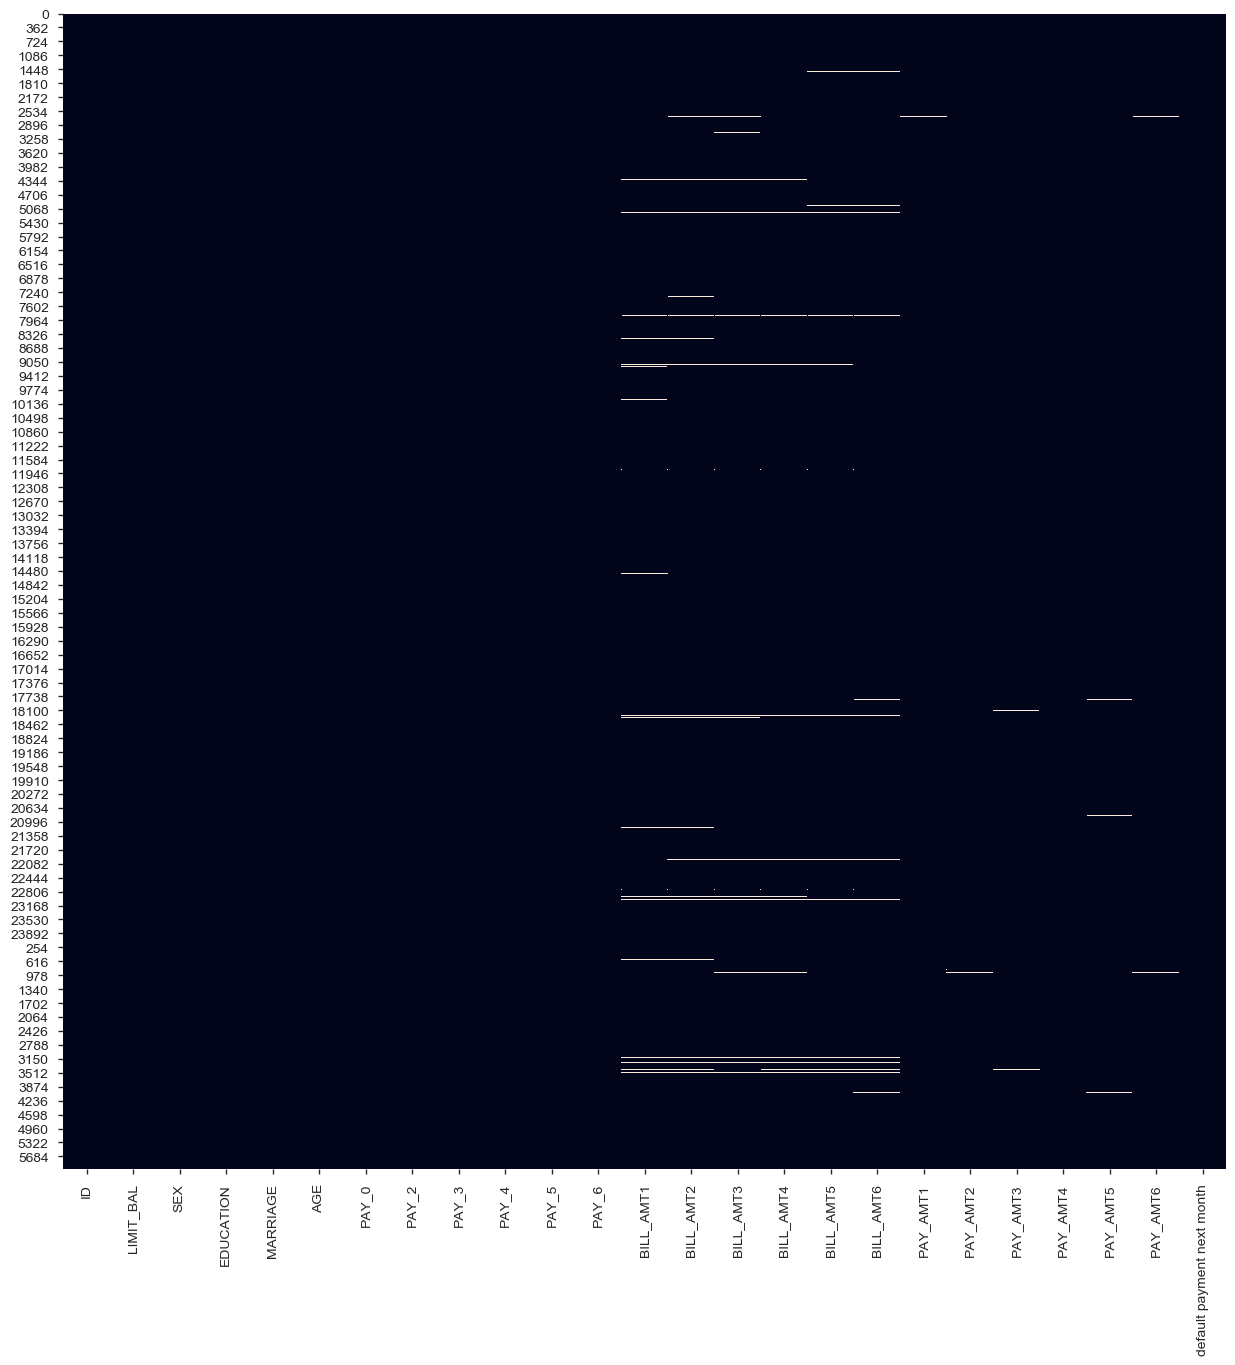

In [169]:
# remove outliners in LIMIT_BAL
all_data['LIMIT_BAL'][all_data['LIMIT_BAL']>750000] = np.nan

# remove outliners in BILL AMTs
all_data["BILL_AMT1"][all_data["BILL_AMT1"]>(67091 +220000)] = np.nan
all_data["BILL_AMT2"][all_data["BILL_AMT2"]>(64006.25 +220000)] = np.nan
all_data["BILL_AMT3"][all_data["BILL_AMT3"]>(60164.75 +220000)] = np.nan
all_data["BILL_AMT4"][all_data["BILL_AMT4"]>(54506 +220000)] = np.nan
all_data["BILL_AMT5"][all_data["BILL_AMT5"]>(50190.5 +220000)] = np.nan
all_data["BILL_AMT6"][all_data["BILL_AMT6"]>(49198.25 +220000)] = np.nan

# remove outliners in PAY AMTs
all_data["PAY_AMT1"][all_data["PAY_AMT1"]>(5006 +200000)] = np.nan
all_data["PAY_AMT2"][all_data["PAY_AMT2"]>(5000 +200000)] = np.nan
all_data["PAY_AMT3"][all_data["PAY_AMT3"]>(4505 +200000)] = np.nan
all_data["PAY_AMT4"][all_data["PAY_AMT4"]>(4013.25 +200000)] = np.nan
all_data["PAY_AMT5"][all_data["PAY_AMT5"]>(4031.5 +200000)] = np.nan
all_data["PAY_AMT6"][all_data["PAY_AMT6"]>(4000 +200000)] = np.nan

# Investigate patterns in the amount of missing data in each column.
plt.subplots(figsize=(15,15))
sns.heatmap(all_data.isnull(), cbar=False)

In [170]:
all_zero_nan = all_data[all_data.isnull().sum(axis=1) == 0]

In [ ]:
#binning the AGE feature which ranges from 21 to 79
bins = [20,30,40,50,60,80]
labels = [1,2,3,4,5]
all_zero_nan['AGE'] = pd.cut(all_zero_nan['AGE'], bins, labels=labels)

sns.countplot(x = 'AGE', hue="default payment next month", data = all_zero_nan)

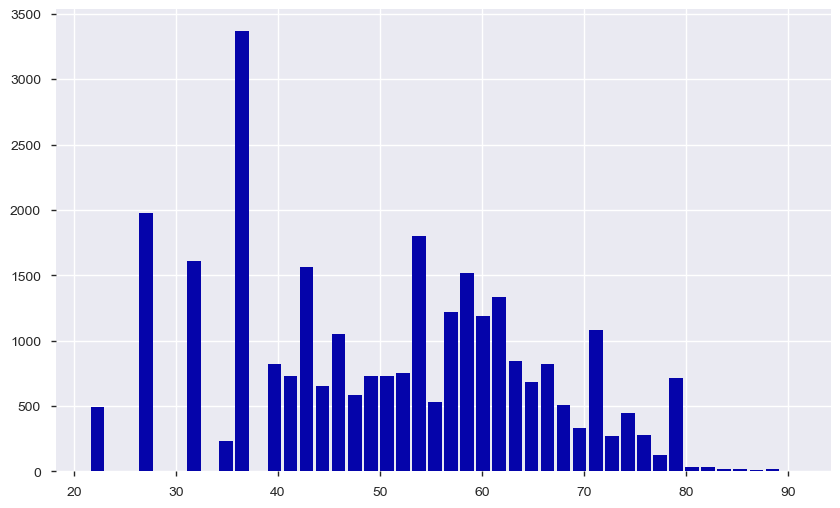

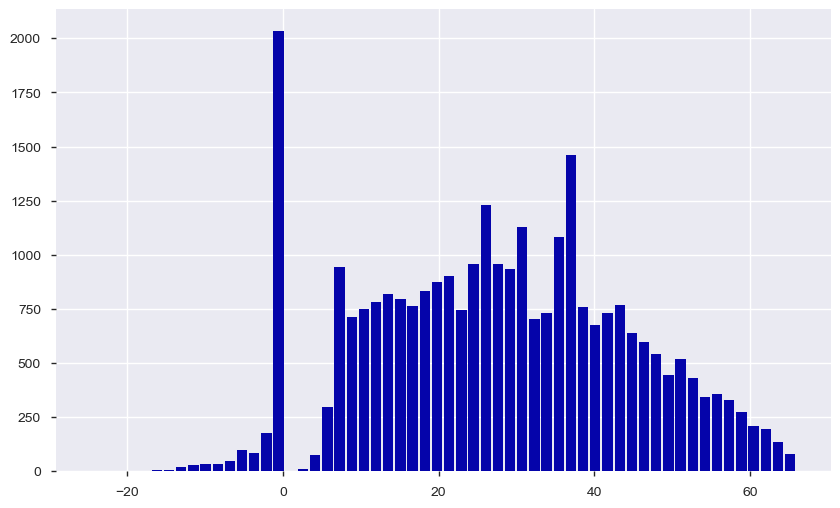

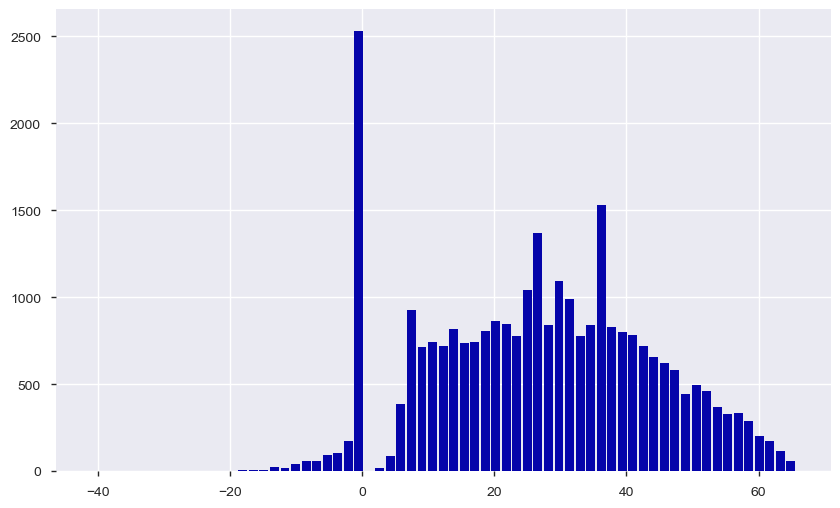

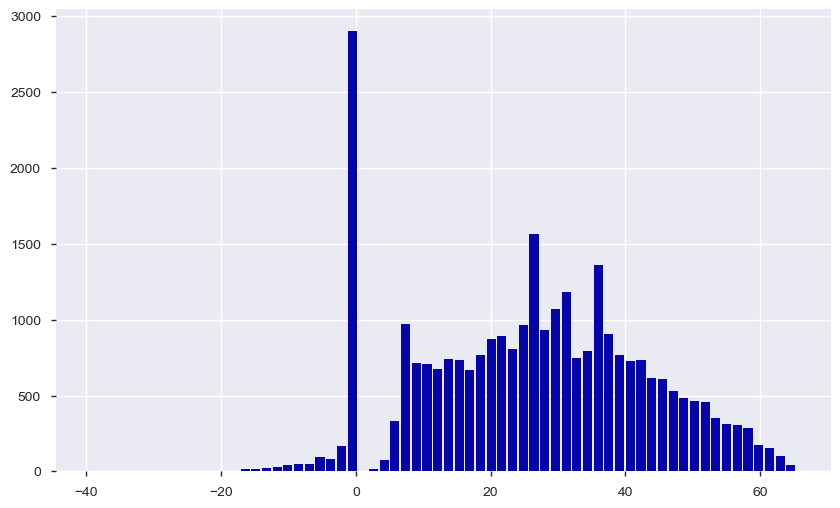

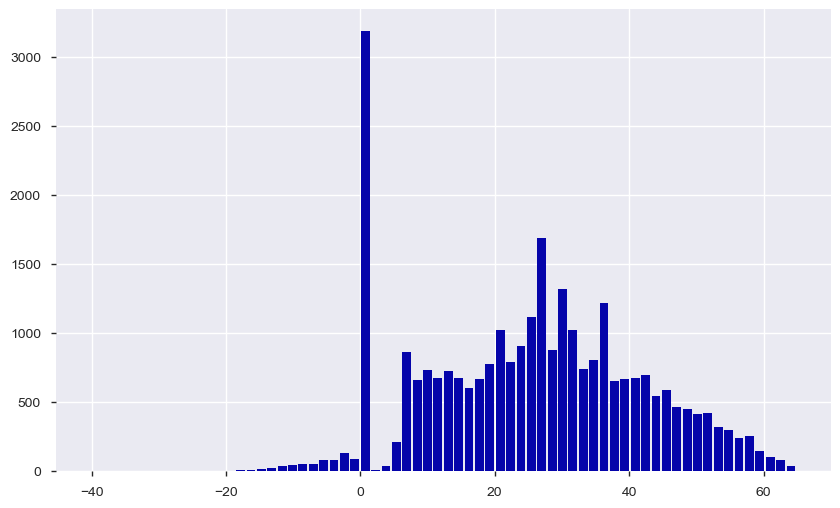

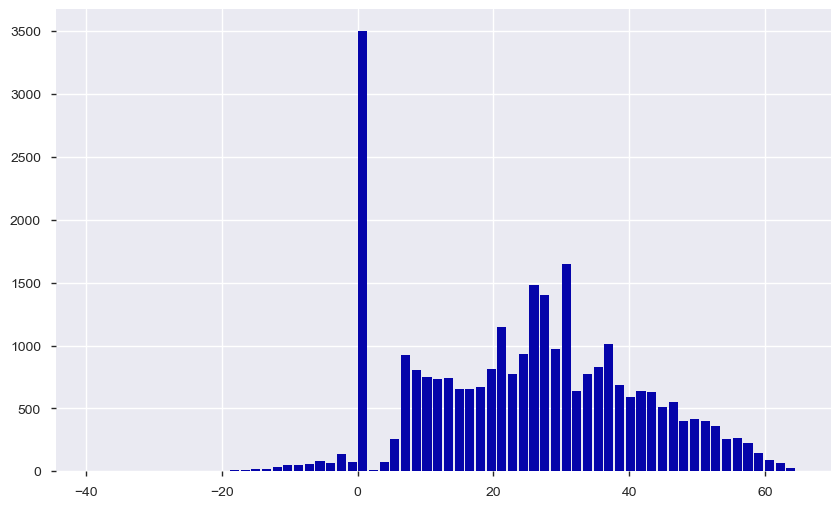

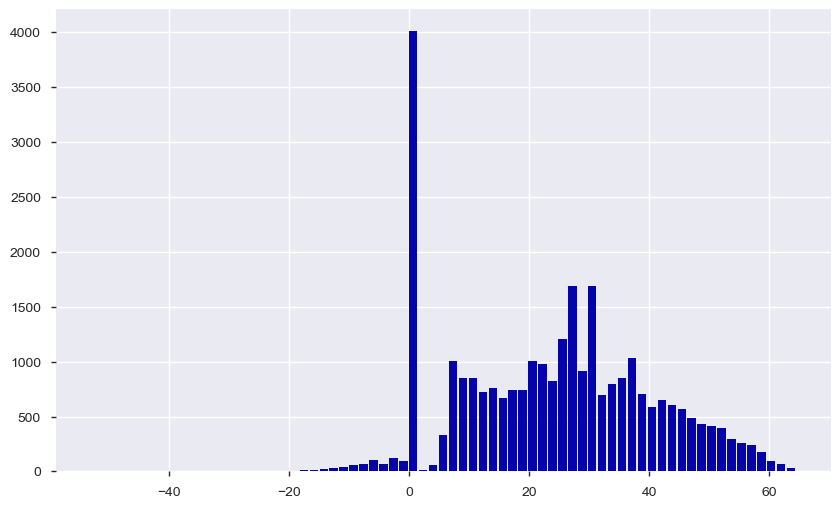

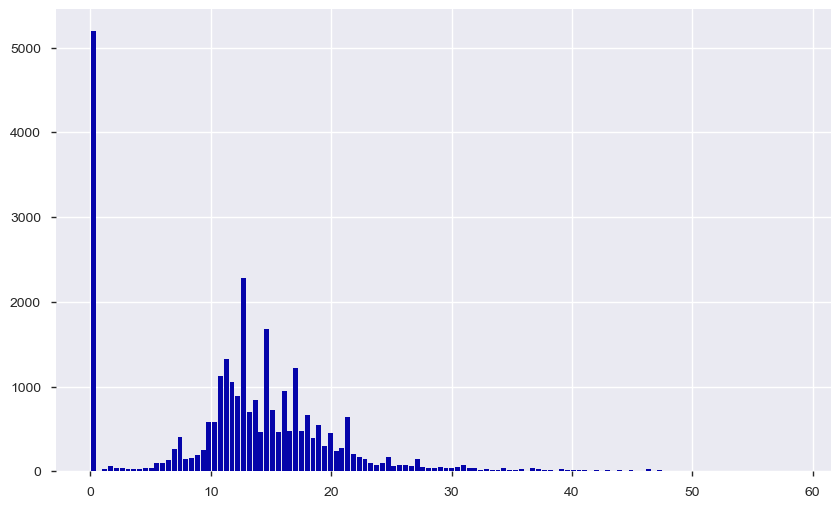

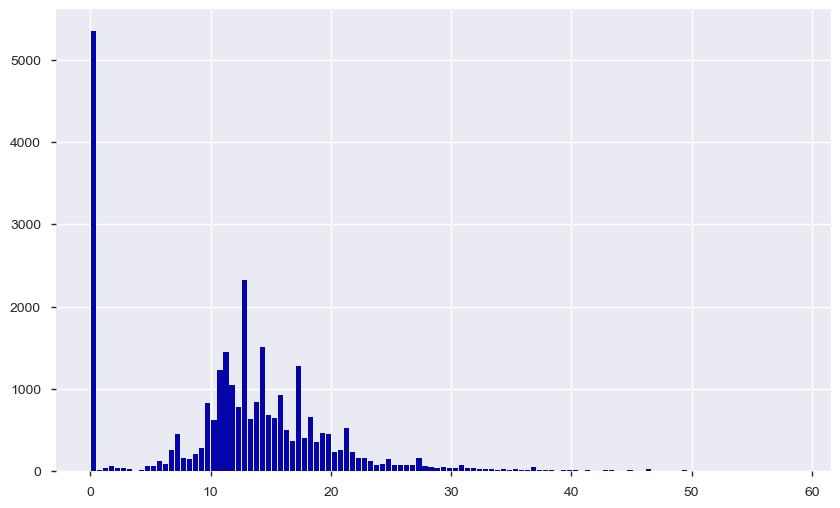

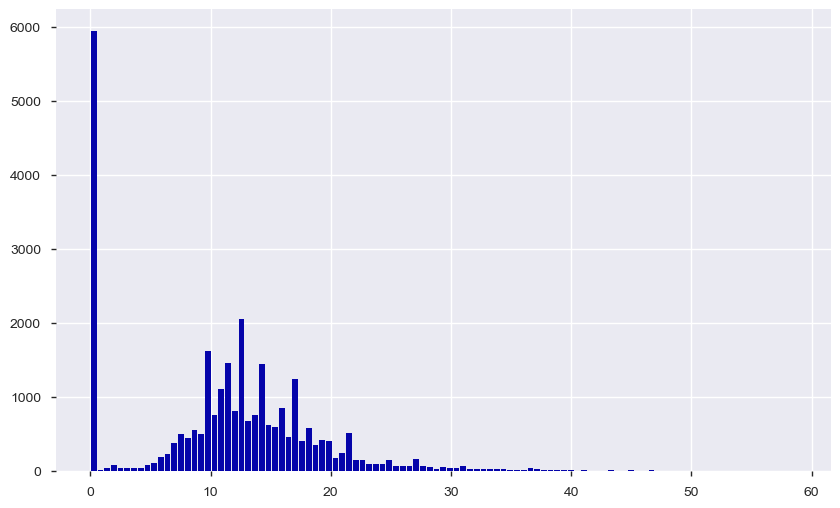

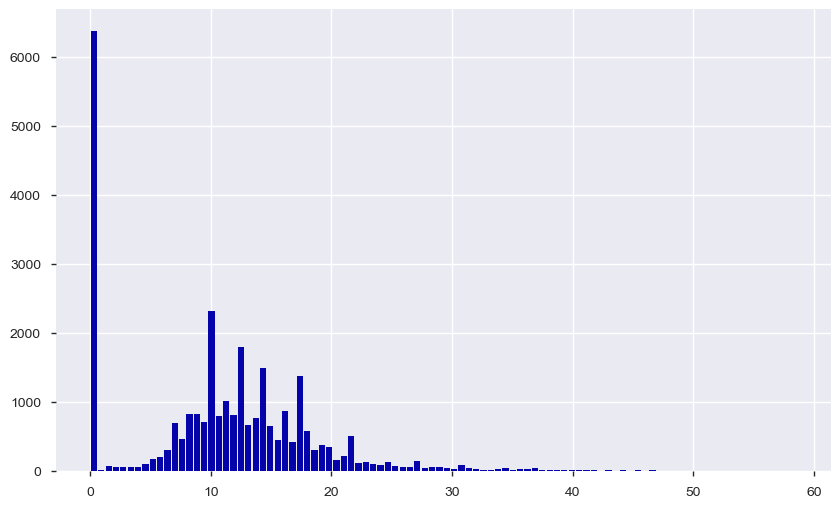

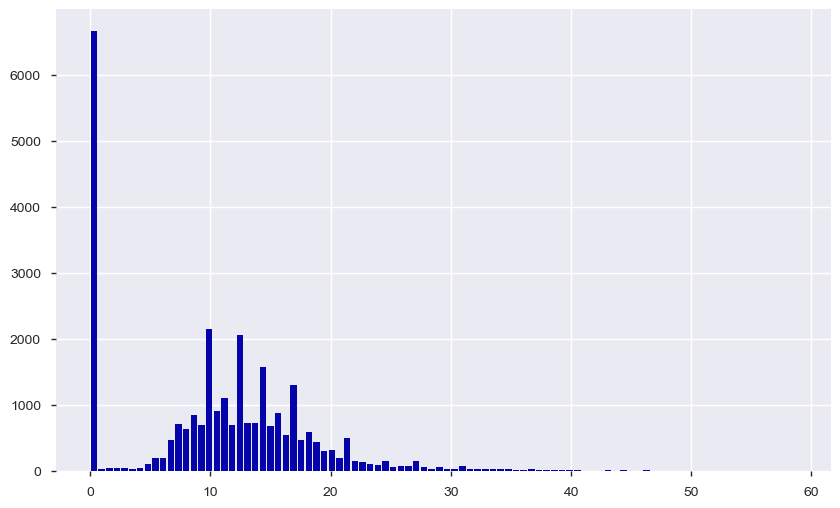

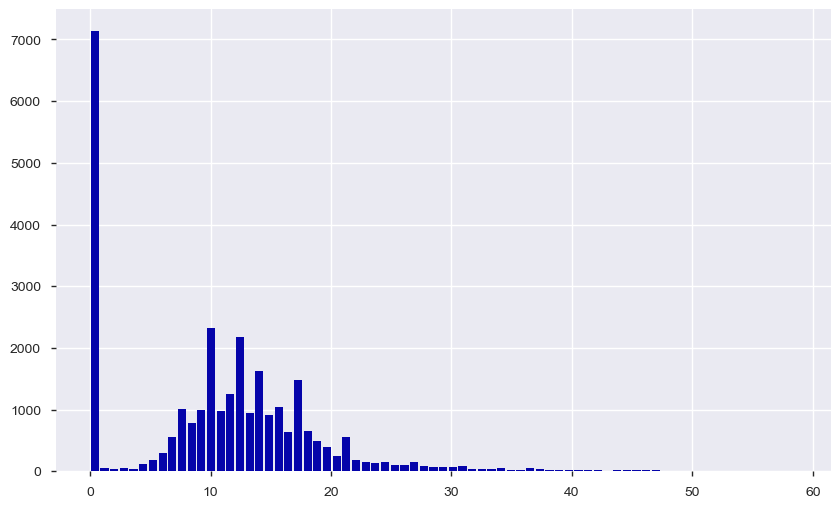

In [172]:
# clean the data
X,Y = clean(all_zero_nan)

In [173]:
pandas_profiling.ProfileReport(all_zero_nan)

Number of variables,26
Number of observations,29117
Total Missing (%),0.0%
Total size in memory,5.6 MiB
Average record size in memory,201.0 B
Numeric,18
Categorical,1
Boolean,2
Date,0
Text (Unique),0
Rejected,5


In [163]:
# Split the 'features' and 'income' data into training and testing sets
train_x, test_x, train_y, test_y= train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 41)

# Show the results of the split
print("Training set has {} samples.".format(train_x.shape[0]))
print("Testing set has {} samples.".format(test_x.shape[0]))

Training set has 23293 samples.
Testing set has 5824 samples.


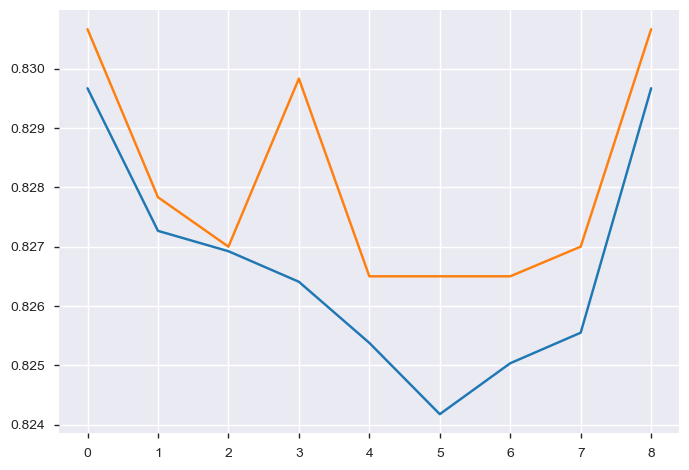

In [151]:
# #test accuracy against the original data

# first = []
# second = []
# for n in range(1,30,4):
#     clf1 = AdaBoostClassifier(random_state=41,n_estimators = n)
#     clf1.fit(train_x,train_y)
#     accuracy1 = clf1.score(test_x,test_y)
#     first.append(accuracy1)
    
    
#     clf2 = AdaBoostClassifier(random_state=41,n_estimators = n)
#     clf2.fit(otrain_x,otrain_y)
#     accuracy2 = clf2.score(otest_x,otest_y)
#     second.append(accuracy2)
    
# first.append(max(first))
# second.append(max(second))
    
# accuracy_table = pd.DataFrame([first, second],columns = range(1,34,4))        
# accuracy_table

# plt.plot(first)
# plt.plot(second)

In [157]:
clf1 = AdaBoostClassifier(random_state=41,n_estimators = 100)
clf1.fit(train_x,train_y)
accuracy1 = clf1.score(test_x,test_y)
first.append(accuracy1)

In [152]:
accuracy_table

,1,5,9,13,17,21,25,29,33
0,0.829670,0.827266,0.826923,0.826408,0.825378,0.824176,0.825034,0.825549,0.829670
1,0.830667,0.827833,0.827000,0.829833,0.826500,0.826500,0.826500,0.827000,0.830667


In [158]:
# importance..............TBC
i1 = clf1.feature_importances_
i1_df= pd.DataFrame(i1.tolist(), index = train_x.columns)
i1_df.columns = ["clf1"]

i2 = clf2.feature_importances_
i2_df= pd.DataFrame(i2.tolist(), index = otrain_x.columns)
i2_df.columns = ["clf2"]

i1_df
# i2_df

,clf1
SEX,0.01
AGE,0.03
PAY_1,0.11
PAY_2,0.01
PAY_3,0.01
PAY_4,0.02
PAY_5,0.00
PAY_6,0.04
PAY_AMT1,0.11
PAY_AMT2,0.07


# 5. Methodology Overview

Start by describing in broad terms your methodology. Include any background reading you may have done and a step by step description of how you have trained and evaluated your model. Describe any feature engineering that you have applied. If you had attempted different approaches prior to landing on your final methodology, then describe those approaches here.


In [90]:
# split the original train test data 
otrain_y = df_train['default payment next month']
otrain_x = df_train
otrain_x.drop('default payment next month', axis = 1,inplace = True)
otrain_x.drop('ID', axis = 1,inplace = True)
otest_y = df_test['default payment next month']
otest_x = df_test
otest_x.drop('default payment next month', axis = 1,inplace = True)
otest_x.drop('ID', axis = 1,inplace = True)

### Model Selection

In [29]:
def train_predict(learner,sample_size, X_train, y_train, X_test, y_test): 
    results = {}
    
    # Fit the learner
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    # Calculate the training time
    results['train_time'] = end-start

    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    results['pred_time'] = end-start
    results['acc_train'] = accuracy_score(y_train,predictions_train)
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    results['f_train'] = fbeta_score(y_train,predictions_train,beta = 3)
    results['f_test'] = fbeta_score(y_test,predictions_test, beta = 3)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__,sample_size))
        
    # Return the results
    return results

In [30]:
tt = []
atr = []
ftr = []
pt = []
at = []
ft = []

# Initialize the models
clf_A = AdaBoostClassifier(random_state = 42)
clf_B = SVC(random_state = 42, gamma = 'auto')
clf_C = KNeighborsClassifier()
clf_D = RandomForestClassifier(random_state = 42)
clf_E = BaggingClassifier(random_state = 42)
clf_F = DecisionTreeClassifier(random_state = 42)
clf_G = GradientBoostingClassifier(random_state = 42)
clf_H = LogisticRegression(random_state = 42)
clf_I = SGDClassifier(random_state = 42)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G, clf_H, clf_I]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = \
    train_predict(clf,24000, train_x, train_y, test_x, test_y)
    
    
for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
    for k, learner in enumerate(results.keys()):
        if j == 0:
            tt.append(results[learner][metric])
        if j == 1:
            atr.append(results[learner][metric])
        if j == 2:
            ftr.append(results[learner][metric])
        if j == 3:
            pt.append(results[learner][metric])
        if j == 4:
            at.append(results[learner][metric])
        if j == 5:
            ft.append(results[learner][metric])   

AdaBoostClassifier trained on 24000 samples.
SVC trained on 24000 samples.
KNeighborsClassifier trained on 24000 samples.
RandomForestClassifier trained on 24000 samples.
BaggingClassifier trained on 24000 samples.
DecisionTreeClassifier trained on 24000 samples.
GradientBoostingClassifier trained on 24000 samples.
LogisticRegression trained on 24000 samples.
SGDClassifier trained on 24000 samples.


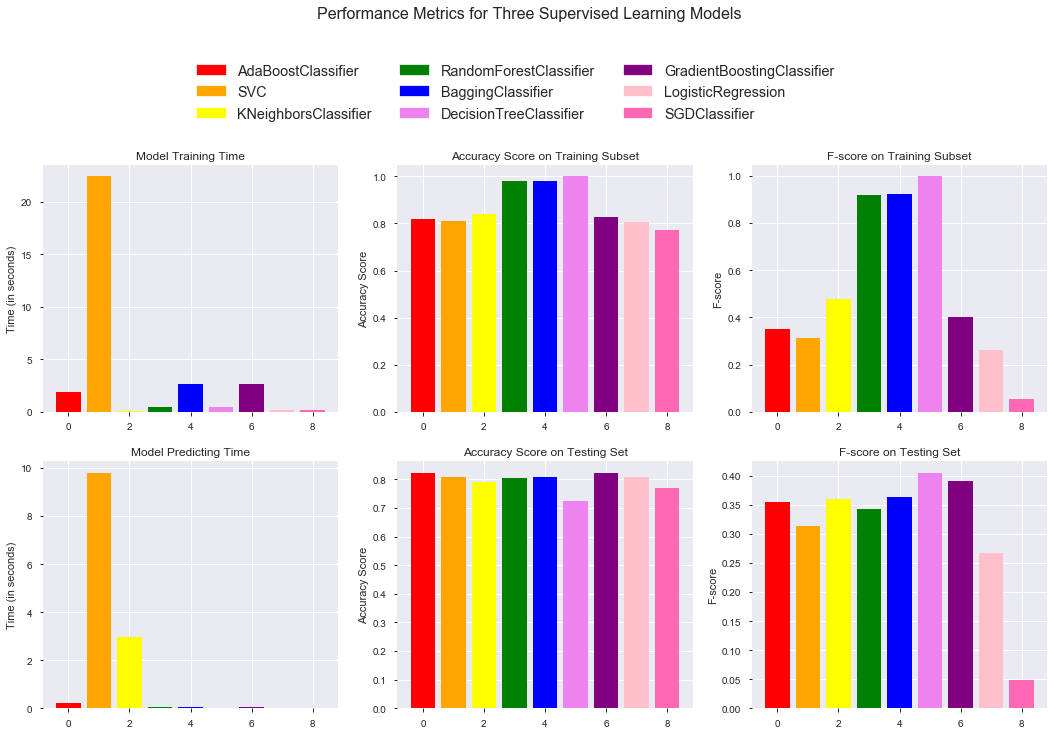

In [31]:
# comparison btw different models using 
fig, ax = plt.subplots(2, 3, figsize = (18,10))
colors = ['red','orange','yellow','green','blue','violet','purple','pink','hotpink']
ax[0,0].bar(range(len(results)), tt, align='center',color = colors)
ax[0,1].bar(range(len(results)), atr, align='center',color = colors)
ax[0,2].bar(range(len(results)), ftr, align='center',color = colors)
ax[1,0].bar(range(len(results)), pt, align='center',color = colors)
ax[1,1].bar(range(len(results)), at, align='center',color = colors)
ax[1,2].bar(range(len(results)), ft, align='center',color = colors)

 # Add titles
ax[0, 0].set_title("Model Training Time")
ax[0, 1].set_title("Accuracy Score on Training Subset")
ax[0, 2].set_title("F-score on Training Subset")
ax[1, 0].set_title("Model Predicting Time")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[1, 2].set_title("F-score on Testing Set")

# Add unique y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Accuracy Score")
ax[0, 2].set_ylabel("F-score")
ax[1, 0].set_ylabel("Time (in seconds)")
ax[1, 1].set_ylabel("Accuracy Score")
ax[1, 2].set_ylabel("F-score")

 # Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.63), loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')

plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
plt.show()

<font color="red"> # fill this in 
    
Based on the above graph, we can see that the best model for this project is .......because......

# 6. Model training/validation

This contains a breakdown of how your model was trained and evaluated.


# Todo list
+ cross validation, grid search
+ argue the model complexity
+ visualise training error and CV error to evaluate the model
+ 

In [183]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

    

classifiers = [
    SVC(random_state = 1, kernel = 'rbf'),    
    DecisionTreeClassifier(random_state = 42, criterion = 'gini'),
    RandomForestClassifier(random_state = 42, criterion = 'gini'),
    KNeighborsClassifier(metric = 'minkowski'),
#     AdaBoostClassifier(random_state = 42)
#     BaggingClassifier(random_state = 42)
#     GradientBoostingClassifier(random_state = 42)
#     LogisticRegression(random_state = 42)

]

classifier_names = [
            'svc', 
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
]

classifier_param_grid = [
            {'svc__C':[1], 'svc__gamma':[0.01]},
            {'decisiontreeclassifier__max_depth':[6,9,11]},
            {'randomforestclassifier__n_estimators':[3,5,6]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,8]},
]
 

def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, param_grid, score = 'accuracy'):
    response = {}
    gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = score)
    search = gridsearch.fit(train_x, train_y)
    print("GridSearch best parameter：", search.best_params_)
    print("GridSearch best score： %0.4lf" %search.best_score_)
    predict_y = gridsearch.predict(test_x)
    print("Accuracy %0.4lf" %accuracy_score(test_y, predict_y))
    response['predict_y'] = predict_y
    response['accuracy_score'] = accuracy_score(test_y,predict_y)
    return response
 
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline = Pipeline([,
            ('pca',PCA()),
            (model_name, model)
    ])
    result = GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid , score = 'accuracy')

/Users/sdu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



GridSearch best parameter： {'svc__C': 1, 'svc__gamma': 0.01}
GridSearch best score： 0.8177
Accuracy 0.8182


/Users/sdu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



GridSearch best parameter： {'decisiontreeclassifier__max_depth': 6}
GridSearch best score： 0.8055
Accuracy 0.8078


/Users/sdu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



GridSearch best parameter： {'randomforestclassifier__n_estimators': 6}
GridSearch best score： 0.7936
Accuracy 0.7962


/Users/sdu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



GridSearch best parameter： {'kneighborsclassifier__n_neighbors': 8}
GridSearch best score： 0.8038
Accuracy 0.8050


In [32]:
# import library
from sklearn.metrics import make_scorer
X_train = otrain_x
y_train = otrain_y
X_test = otest_x
y_test = otest_y

As we can see below, we are using all the features without selection and merge. We are doing the the raw machine learning and trying to use GridSearchCV to improve.

## 1.AdaBoostClassifier

In [296]:
# define the classifier.
clf = AdaBoostClassifier(n_estimators=10, random_state=0)
# training the classifier
clf.fit(train_x, train_y)
# do our predictions on the test
predictions = clf.predict(test_x)
# see how good we did on the test
accuracy_score(y_true = test_y, y_pred = predictions)

0.8168333333333333

In [297]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix"', cmap = plt.cm.Blues) :
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)
 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def show_metrics():
    tp = cm.stats()['TP']
    fn = cm.stats()['FN']
    fp = cm.stats()['FP']
    tn = cm.stats()['TN']
    print('Precision: {:.3f}'.format(tp/(tp+fp)))
    print('Recall: {:.3f}'.format(tp/(tp+fn)))
    print('F1 score: {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn))))))

    
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2, color = 'b')
    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False       4480   186     4666
True         913   421     1334
__all__     5393   607     6000
------------------------------
Precision: 0.694
Recall: 0.316
F1 score: 0.434


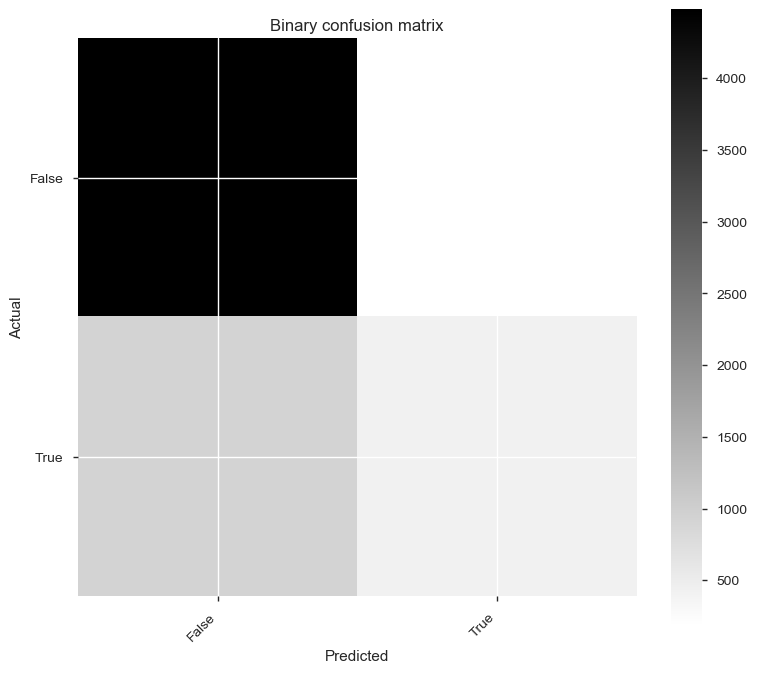

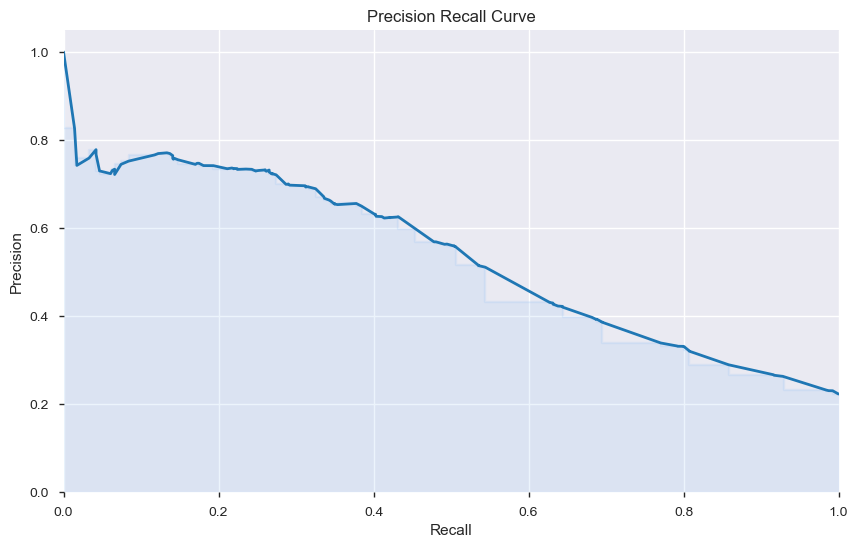

In [298]:
cm = ConfusionMatrix(test_y.tolist(), predictions.tolist())
print("Confusion matrix:\n%s" % cm)
cm.plot()
cm.stats()# to retrieve the dictionary 
print("-"*30)
show_metrics()
score_y = clf.decision_function(test_x)
precision, recall, thresholds = precision_recall_curve(test_y, score_y)
fig, ax = plt.subplots(figsize=(10,6))
plot_precision_recall()

Test on the raw classifier, what we mean by raw is 'by some not too bad hyperparamers'. The only requirements for the hyperparamers here are 'not too complex tree' and 'reliable and acceprable answers'

In [34]:
# define the classifier.
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
# training the classifier
clf.fit(otrain_x, otrain_y)
# do our predictions on the test
predictions = clf.predict(otest_x)
# see how good we did on the test
accuracy_score(y_true = otest_y, y_pred = predictions)

0.8283333333333334

The score is not too bad as expected, let's how about feed in the best hyperparameters gained by cross-validation in grid(GridSearchCV).

In [35]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [100, 300],
              'algorithm': ['SAMME', 'SAMME.R'],
              'learning_rate' : [0.6, 0.8, 1.0]}

# create the grid 
grid_search_tree = GridSearchCV(AdaBoostClassifier(), param_grid, cv = 5, scoring= 'accuracy')

#training
grid_search_tree.fit(otrain_x, otrain_y)
#let's see the best estimator
print(grid_search_tree.best_estimator_)
#with its score
print(np.abs(grid_search_tree.best_score_))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=None)
0.8160833333333334


Let's see the classifier with predicted best hyperparamers gained by cross-validation through GridSearchCV

In [36]:
classifier = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=None)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.8313333333333334

## 2.DecisionTreeClssifier

In [37]:
# define the clssifier and fit with the train data
classifier = DecisionTreeClassifier(max_depth=500, random_state=14)
classifier.fit(X_train, y_train)
# do our predictions on the test and see the scores
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.7296666666666667

In [38]:
# define the parameters grid
param_grid = {'max_depth': np.arange(8, 10),
             'criterion' : ['gini','entropy'],
             'max_leaf_nodes': [5,10,20,100],
             'min_samples_split': [2, 5, 10, 20]}

# create the grid
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring= 'accuracy')
grid_tree.fit(X_train, y_train)

#let's see the best estimator
print(grid_tree.best_estimator_)
#with its score
print(np.abs(grid_tree.best_score_))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.8168333333333333


In [39]:
classifier = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.8306666666666667

## GradientBoostingClassifier

In [40]:
# define the clssifier and fit with the train data
classifier = GradientBoostingClassifier()
classifier.fit(X_train, y_train)
# do our predictions on the test and see the scores
predictions = classifier.predict(X_test)
accuracy_score(y_true = y_test, y_pred = predictions)

0.8325

In [41]:
# define the parameters grid
# param_grid = {'max_depth':range(5,16,1),
#             'min_samples_split':range(200,1001,200),
#              'max_features':range(7,20,2)}

# create the grid
# grid_tree = GridSearchCV(GradientBoostingClassifier(), param_grid, cv = 5, scoring= 'accuracy')
# grid_tree.fit(X_train, y_train)

#let's see the best estimator
# print(grid_tree.best_estimator_)
#with its score
# print(np.abs(grid_tree.best_score_))

In [42]:
# classifier = GradientBoostingClassifier()
# classifier.fit(X_train, y_train)
# predictions = classifier.predict(X_test)
# accuracy_score(y_true = y_test, y_pred = predictions)
# some tests

# 7. Results

Here you show the results that you obtain using your model on the training data. If you have multiple variations or approaches, this is where you compare them.


# 8. Final predictions

This is the section where you perform your final predictions on the test set using the model that you have trained in the previous section.


# 9. References

https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5